<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/AGENTIC-MODULE3-AdaptiveWindowAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Loaded MLP model from /content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_Daily.keras
AdaptiveWindowAgent adaptive_window_agent initialized
Loading your actual dataset...
Loaded Long_train shape: (3627, 50, 12)
Testing with last 100 sequences: (100, 50, 12)

Starting real-time VAR testing...

Sample 1: Using flattened sequence of size 600
Sample   1: MLP= 2, MSE=0.0000, MAE=0.0023 Avg_MSE=0.0000

Sample 2: Using flattened sequence of size 600
Sample   2: MLP= 2, MSE=0.0000, MAE=0.0037 Avg_MSE=0.0000

Sample 3: Using flattened sequence of size 600
Sample   3: MLP= 2, MSE=0.0001, MAE=0.0058 Avg_MSE=0.0000

Sample 4: Using flattened sequence of size 600
Sample   4: MLP= 2, MSE=0.0001, MAE=0.0045 Avg_MSE=0.0000

Sample 5: Using flattened sequence of size 600
Sample   5: MLP= 2, MSE=0.0000, MAE=0.0042 Avg_MSE=0.0000

Sample 6: Using flattened sequence of size 600
Sample   6: MLP= 2, MSE=0.0001, MAE=0.0056 Avg_MSE=0.0001

Sample 7: Using flattened sequence of size 600
Sam

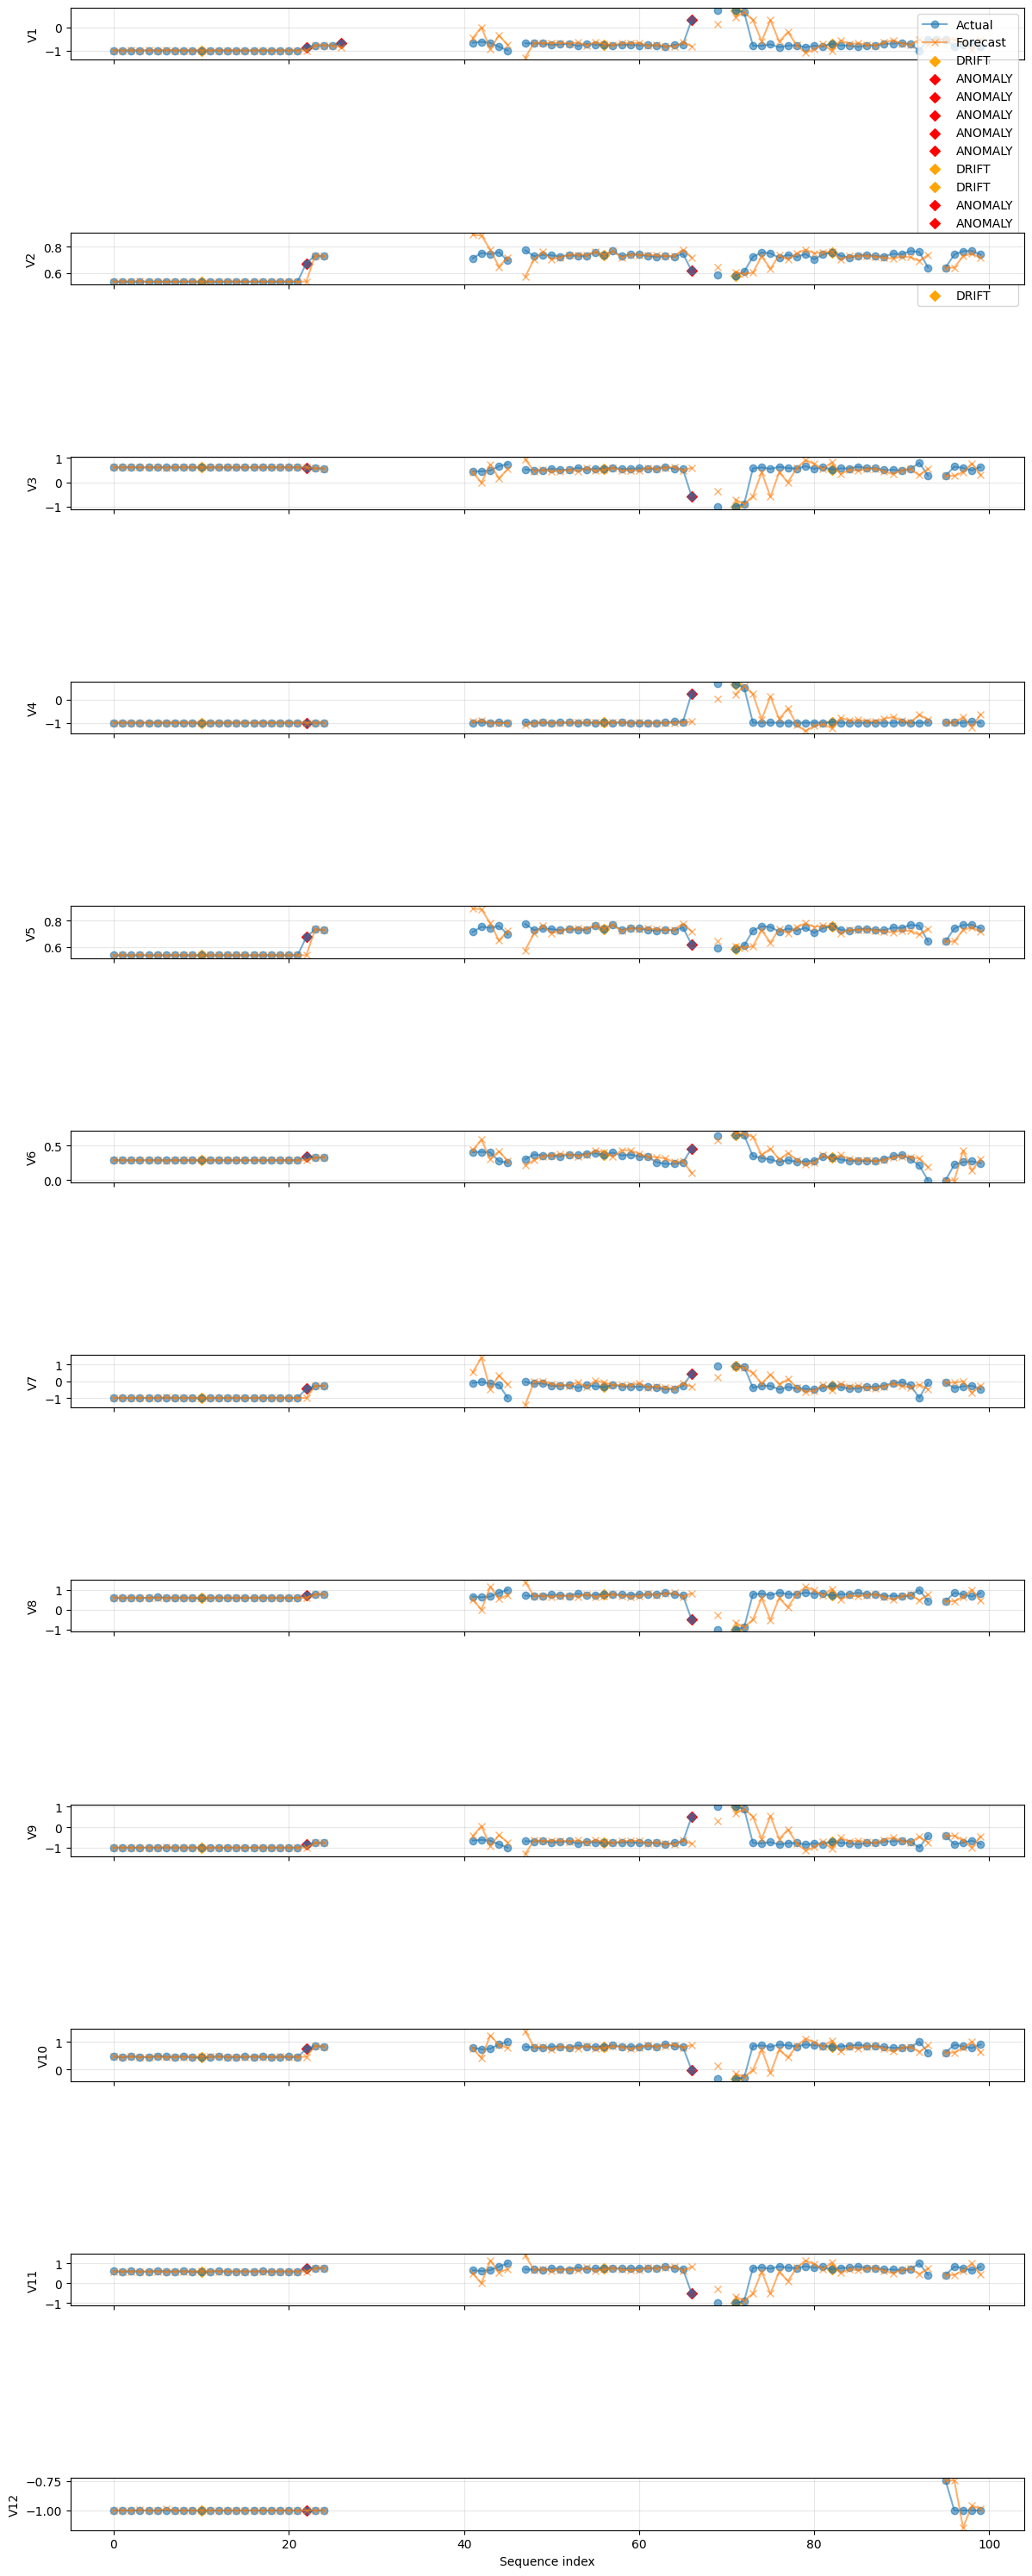

✅ Performance state saved to real_data_test_results.json

Test results saved to: real_data_test_results.json


In [2]:
# agents/adaptive_window_agent.py
import numpy as np
import pandas as pd
import pickle
import json
import os
from collections import deque
from typing import Dict, Any
import datetime as dt
import logging
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
import keras
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

logger = logging.getLogger(__name__)

# =====================================================
# AdaptiveWindowAgent (improved version)
# =====================================================
import numpy as np
import pandas as pd
import pickle, os, logging, datetime as dt
from collections import deque
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
import keras

logger = logging.getLogger(__name__)

class AdaptiveWindowAgent:
    """
    Adaptive Window Agent:
    - Predicts window size using MLP
    - Evaluates forecast with VAR
    - Monitors anomalies & drift with adaptive thresholds
    - Outputs severity scores + suppresses redundant events
    """

    def __init__(self, agent_id="adaptive_window_agent",
                 model_path=None, checkpoint_path=None):
        self.agent_id = agent_id
        self.model_path = model_path or "/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_Daily.keras"
        self.checkpoint_path = checkpoint_path

        # Core model
        self.model = None
        self.transformer = StandardScaler()
        self.transformer_fitted = False
        self.is_model_loaded = False

        # Histories
        self.prediction_history = deque(maxlen=1000)
        self.mse_history = deque(maxlen=200)
        self.mae_history = deque(maxlen=200)

        # Event detection params
        self.drift_detection_window = 20
        self.drift_threshold_mse = 1.5   # stricter
        self.drift_threshold_mae = 1.5
        self.consecutive_poor_predictions = 0
        self.cooldown_counter = 0

        # Stats
        self.performance_stats = {
            'total_predictions': 0,
            'avg_mse': 0.0,
            'avg_mae': 0.0,
            'last_retrain_time': None,
            'drift_events': 0,
            'anomaly_events': 0,
            'retraining_events': 0
        }

        # Retraining buffers
        self.retraining_data = {
            'x_buffer': deque(maxlen=10000),
            'y_buffer': deque(maxlen=10000)
        }

        self.load_model()
        print(f"AdaptiveWindowAgent {self.agent_id} initialized")

    # ------------------- Model -------------------

    def load_model(self):
        try:
            if os.path.exists(self.model_path):
                self.model = keras.models.load_model(self.model_path)
                self.is_model_loaded = True
                print(f"✅ Loaded MLP model from {self.model_path}")

                # Try to load transformer
                transformer_path = self.model_path.replace('.keras', '_transformer.pkl')
                if os.path.exists(transformer_path):
                    with open(transformer_path, 'rb') as f:
                        self.transformer = pickle.load(f)
                    self.transformer_fitted = True
                else:
                    # Fit transformer from true window labels
                    y_original = np.load(
                        "/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/generated-data-true-window2.npy"
                    )
                    self.transformer.fit(y_original.reshape(-1, 1))
                    self.transformer_fitted = True
                    with open(transformer_path, 'wb') as f:
                        pickle.dump(self.transformer, f)
                    print("⚠️ No transformer found, fitted a new one.")
            else:
                print(f"❌ Model not found at {self.model_path}")
        except Exception as e:
            print(f"❌ Error loading model: {e}")

    # ------------------- Forecast Eval -------------------
    from sklearn.ensemble import RandomForestRegressor
    import numpy as np

    def evaluate_forecast_performance(self, sequence_3d, predicted_window, n_future=1):
        """
        EXACT REPLICATION of your original paper's forecasting-based
        window evaluation method, adapted for the agentic framework.

        - Uses all sensor histories in each window (multivariate)
        - Flattens into a single feature vector
        - Predicts ONE chosen target variable (univariate regression)
        - Computes error metrics: MSE and MAE
        - Returns detailed diagnostic info for drift/anomaly detection
        """

        try:
            seq = np.asarray(sequence_3d)   # shape (T, num_features)
            T, F = seq.shape

            # Ensure predicted window is valid
            W = int(predicted_window)
            if W < 2:
                W = 2
            if W > T - n_future - 1:
                W = max(2, T - n_future - 1)

            # Choose ONE sensor to predict (change if needed)
            target_sensor_index = 1   # Use second sensor by default (same as your code)

            # -----------------------------
            # 1. Build Sliding Windows
            # -----------------------------
            X_list = []
            y_list = []

            # Build multivariate → univariate supervised data
            for t in range(W, T - n_future + 1):
                past_window = seq[t-W:t, :]      # (W, F)
                x_vec = past_window.reshape(-1)  # flatten into (W * F,)
                target_val = seq[t + n_future - 1, target_sensor_index]

                X_list.append(x_vec)
                y_list.append(target_val)

            # Convert to arrays
            X = np.array(X_list)
            y = np.array(y_list)

            if len(X) < 5:
                return {
                    "mse": 9999,

                    "forecast_success": False,
                    "error": "Insufficient samples for regression",
                    "method": "RF-multivariate-univariate"
                }

            # -----------------------------
            # 2. Time-Aware 70/30 Split
            # -----------------------------
            split = int(np.ceil(0.7 * len(X)))
            X_train, X_test = X[:split], X[split:]
            y_train, y_test = y[:split], y[split:]

            if len(X_test) == 0:
                return {
                    "mse": 9999,

                    "forecast_success": False,
                    "error": "No test samples available",
                    "method": "RF-multivariate-univariate"
                }

            # -----------------------------
            # 3. Random Forest Regressor (Best from your paper)
            # -----------------------------
            rf = RandomForestRegressor(
                n_estimators=100,
                max_depth=None,
                random_state=42,
                n_jobs=-1
            )

            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)

            # -----------------------------
            # 4. Compute Errors (Consistent with your paper)
            # -----------------------------
            mse = float(np.mean((y_test - y_pred)**2))


            # -----------------------------
            # 5. Return Results
            # -----------------------------
            return {
                "mse": mse,

                "forecast_success": True,
                "actual_values": y_test.tolist(),
                "predicted_values": y_pred.tolist(),
                "window_size_used": W,
                "target_sensor_index": target_sensor_index,
                "method": "RF-multivariate-univariate"
            }

        except Exception as e:
            return {
                "mse": 9999,

                "forecast_success": False,
                "error": str(e),
                "method": "RF-multivariate-univariate"
            }


# ------------------- Persistence fallback -------------------

    def _persistence_forecast(self, df, df_test):
        """
        Persistence fallback for RF evaluation.
        Last-value-carried-forward for each feature.
        Triggered when RF completely fails for this sequence.
        """
        try:
            # Last observed value of each feature
            last_values = df.iloc[-1].values  # shape = (num_features,)

            # Predict only the next step (1 step forecast)
            predicted_vals = last_values.copy()

            # Actual next-step values
            actual = df_test.iloc[0].values  # shape = (num_features,)

            # Compute error
            mse = float(np.mean((actual - predicted_vals) ** 2))


            return {
                'mse': mse,
                'mae': mae,
                'forecast_success': True,
                'actual_values': actual.tolist(),
                'predicted_values': predicted_vals.tolist(),
                'used_columns': list(df.columns),
                'method': 'Persistence',
                'note': 'persistence_fallback'
            }

        except Exception as e:
            return {
                'mse': 9999,
                'mae': 9999,
                'forecast_success': False,
                'error': str(e),
                'method': 'Persistence',
                'note': 'persistence_fallback_failed'
            }


    # ------------------- Prediction -------------------

    def predict_window_size(self, feature_vector, sequence_3d):
        if not self.is_model_loaded:
            return {'predicted_window': 20, 'error': "Model not loaded"}

        try:
            if feature_vector.ndim == 1:
                feature_vector = feature_vector.reshape(1, -1)

            pred_raw = self.model.predict(feature_vector, verbose=0)
            if self.transformer_fitted:
                predicted_window = int(round(self.transformer.inverse_transform(pred_raw)[0, 0]))
            else:
                predicted_window = int(round(pred_raw[0, 0]))

            # Evaluate
            forecast_metrics = self.evaluate_forecast_performance(sequence_3d, predicted_window, n_future=1)

            if forecast_metrics.get("forecast_success", False):
                self.mse_history.append(forecast_metrics["mse"])
                self.mae_history.append(forecast_metrics["mae"])
                self.performance_stats['total_predictions'] += 1
                self.performance_stats['avg_mse'] = np.mean(self.mse_history)
                self.performance_stats['avg_mae'] = np.mean(self.mae_history)

            # Event check
            event, sev = self._check_for_event()

            # Save history
            record = {
                'timestamp': dt.datetime.now(),
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'event_type': event,
                'severity': sev
            }
            self.prediction_history.append(record)

            return {
                'predicted_window': predicted_window,
                'forecast_metrics': forecast_metrics,
                'event_type': event,
                'severity': sev,
                'performance_stats': self.get_recent_performance()
            }
        except Exception as e:
            return {'predicted_window': 20, 'error': str(e)}

    # ------------------- Event Logic -------------------

    def _check_for_event(self):
        if len(self.mse_history) < self.drift_detection_window:
            return None, 0.0

        mse_vals = np.array(self.mse_history)[-self.drift_detection_window:]
        mae_vals = np.array(self.mae_history)[-self.drift_detection_window:]

        mean_mse = np.mean(mse_vals)
        median_mse = np.median(mse_vals)
        std_mse = np.std(mse_vals) + 1e-6
        last_mse = mse_vals[-1]

        # Normalized deviation
        z_mse = (last_mse - mean_mse) / std_mse

        # ---------- ANOMALY DETECTION (RF-optimized) ----------
        if z_mse > 4.0:  # 4σ rule
            self.performance_stats['anomaly_events'] += 1
            severity = min(10, float(z_mse))
            return "ANOMALY", severity

        # ---------- DRIFT DETECTION ----------
        # EMA smoother
        ema_mse = 0.3 * mean_mse + 0.7 * median_mse

        # Drift when long-term EMA rises + persists
        if ema_mse > median_mse * 1.15:  # 15% rise in baseline
            self.consecutive_poor_predictions += 1
            if self.consecutive_poor_predictions >= 5 and self.cooldown_counter == 0:
                self.performance_stats['drift_events'] += 1
                self.cooldown_counter = 10
                severity = float(ema_mse / median_mse) - 1
                return "DRIFT", severity
        else:
            self.consecutive_poor_predictions = 0

        if self.cooldown_counter > 0:
            self.cooldown_counter -= 1

        return None, 0.0

    # ------------------- Helpers -------------------

    def get_recent_performance(self):
        successful_predictions = [
            p for p in list(self.prediction_history)[-50:]
            if p.get('forecast_metrics', {}).get('forecast_success', False)
        ]
        return {
            'total_predictions': len(self.prediction_history),
            'successful_predictions': len(successful_predictions),
            'success_rate': len(successful_predictions) / max(len(self.prediction_history), 1),
            'drift_events': self.performance_stats['drift_events'],
            'anomaly_events': self.performance_stats['anomaly_events'],
            'retraining_events': self.performance_stats['retraining_events'],
            'recent_mse': float(np.mean(list(self.mse_history)[-10:])) if self.mse_history else 0,
            'avg_mse': float(np.mean(self.mse_history)) if self.mse_history else 0,
            'recent_mae': float(np.mean(list(self.mae_history)[-10:])) if self.mae_history else 0,
            'avg_mae': float(np.mean(self.mae_history)) if self.mae_history else 0,
            'transformer_fitted': self.transformer_fitted
        }


    def save_performance_state(self, filepath: str):
        """Save performance statistics + prediction history to JSON"""
        try:
            state = {
                'performance_stats': self.performance_stats.copy(),
                'prediction_history': list(self.prediction_history)[-100:],  # last 100
                'mse_history': list(self.mse_history),
                'mae_history': list(self.mae_history),
                'transformer_fitted': self.transformer_fitted
            }
            import json
            with open(filepath, 'w') as f:
                json.dump(state, f, indent=2, default=str)
            print(f"✅ Performance state saved to {filepath}")
        except Exception as e:
            print(f"❌ Failed to save performance state: {e}")


# ==================== PLOTTING ====================
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

def plot_all_features_forecasts(test_sequences, agent, max_features=12):
    all_actual, all_forecast, event_points, method_points = [], [], [], []

    for i, seq in enumerate(test_sequences):
        result = agent.predict_window_size(seq.flatten(), seq)
        fm = result.get("forecast_metrics", {})
        if not fm.get("forecast_success", False):
            continue

        # Prepare rows
        actual_row = [np.nan] * max_features
        forecast_row = [np.nan] * max_features

        # Align actual vs predicted
        n_vals = min(len(fm.get("actual_values", [])), len(fm.get("predicted_values", [])))
        for j in range(n_vals):
            if "used_columns" in fm and j < len(fm["used_columns"]):
                try:
                    idx = int(fm["used_columns"][j].replace("V", "")) - 1
                except:
                    idx = j
            else:
                idx = j

            if idx < max_features:
                actual_row[idx] = fm["actual_values"][j]
                forecast_row[idx] = fm["predicted_values"][j]

        all_actual.append(actual_row)
        all_forecast.append(forecast_row)

        # Track anomaly/drift events
        if result.get("event_type", None):
            event_points.append((i, result["event_type"]))

        # Track which forecast method was used
        method_used = fm.get("method", "RF")  # default assume VAR
        method_points.append((i, method_used))

    if not all_actual:
        print("⚠️ No valid forecasts to plot")
        return

    # Convert to arrays
    actual_matrix = np.array(all_actual)
    forecast_matrix = np.array(all_forecast)
    timestamps = np.arange(len(actual_matrix))

    # Plot
    fig, axes = plt.subplots(max_features, 1, figsize=(12, 2.5 * max_features), sharex=True)

    for idx, ax in enumerate(axes):
        ax.plot(timestamps, actual_matrix[:, idx], label="Actual", marker="o", alpha=0.6)
        ax.plot(timestamps, forecast_matrix[:, idx], label="Forecast", marker="x", alpha=0.6)

        # Mark anomaly/drift events
        for (t, etype) in event_points:
            ax.scatter(t, actual_matrix[t, idx],
                       color="red" if etype == "ANOMALY" else "orange",
                       marker="D",
                       label=etype if idx == 0 else "")

        # Mark forecast method changes
        for (t, m) in method_points:
            if m == "AR":
                ax.scatter(t, forecast_matrix[t, idx], color="blue", marker="s",
                           label="AR" if idx == 0 else "")
            elif m == "Persistence":
                ax.scatter(t, forecast_matrix[t, idx], color="green", marker="^",
                           label="Persistence" if idx == 0 else "")

        ax.set_ylabel(f"V{idx+1}")
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.legend()

    axes[-1].set_xlabel("Sequence index")
    plt.tight_layout()
    plt.show()


# ==================== MAIN TEST LOOP ====================
if __name__ == "__main__":
    # Initialize the agent
    agent = AdaptiveWindowAgent(
        model_path="/content/drive/MyDrive/PHD/2025/DGRNet-MLP-Versions/METROPM_MLP_model_Daily.keras"
    )

    print("Loading your actual dataset...")
    Long_train = np.load('/content/drive/MyDrive/PHD/2025/TEMP_OUTPUT_METROPM/multivariate_long_sequences-TRAIN-Daily-DIRECT-VAR.npy')
    print(f"Loaded Long_train shape: {Long_train.shape}")

    # Last 100 sequences for test
    test_sequences = Long_train[1300:1400]
    print(f"Testing with last {len(test_sequences)} sequences: {test_sequences.shape}")

    print("\nStarting real-time Random Forest testing...")
    print("=" * 70)

    for i, sequence_3d in enumerate(test_sequences, start=1):
        features = sequence_3d.flatten()
        print(f"\nSample {i}: Using flattened sequence of size {len(features)}")

        result = agent.predict_window_size(features, sequence_3d=sequence_3d)
        forecast_metrics = result.get('forecast_metrics', {})
        event_type = result.get('event_type', None)
        error_msg = result.get('error', None)

        if error_msg:
            print(f"Sample {i}: ERROR - {error_msg}")
            continue

        if forecast_metrics.get('forecast_success', False):
            mse_val = forecast_metrics['mse']
            mae_val = forecast_metrics['mae']
            mlp_pred = result.get('predicted_window', 0)
            performance = agent.get_recent_performance()

            print(f"Sample {i:3d}: MLP={mlp_pred:2d}, "
                  f"MSE={mse_val:6.4f}, MAE={mae_val:6.4f} "
                  f"Avg_MSE={performance.get('recent_mse', 0):6.4f}")

            if event_type:
                print(f"*** {event_type.upper()} DETECTED at sample {i} ***")

        else:
            print(f"Sample {i:3d}: Forecast evaluation failed")

    print("\n" + "=" * 70)
    print("FINAL PERFORMANCE SUMMARY")
    print("=" * 70)

    final_perf = agent.get_recent_performance()
    print(f"Total predictions: {final_perf.get('total_predictions', 0)}")
    print(f"Successful predictions: {final_perf.get('successful_predictions', 0)}")
    print(f"Success rate: {final_perf.get('success_rate', 0):.2%}")
    print(f"Average MSE: {final_perf.get('recent_mse', 0):.4f}")
    print(f"Average MAE: {final_perf.get('recent_mae', 0):.4f}")
    print(f"Anomaly events: {final_perf.get('anomaly_events', 0)}")
    print(f"Drift events: {final_perf.get('drift_events', 0)}")
    print(f"Retraining events: {final_perf.get('retraining_events', 0)}")
    print(f"Transformer fitted: {final_perf.get('transformer_fitted', False)}")

    plot_all_features_forecasts(test_sequences, agent, max_features=12)

    agent.save_performance_state("real_data_test_results.json")
    print(f"\nTest results saved to: real_data_test_results.json")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')